# Imports & Globals

In [1]:
import pickle
import pandas as pd
import numpy as np
from yaml import safe_load
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from StringProcessing import preprocessInput, encode_pad_tag, balance_complete_set

In [3]:
from SiameseModel import CosineDistance, ContrastiveLoss 

tf.version:  2.9.1
tf.keras.version:  2.9.0
tf.config.devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-09-14 20:50:46.191683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:46.214977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:46.215133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:46.215617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
from ModelEvaluation import find_Model_ranks, find_Levenshtein_ranks, find_Gesalt_ranks

In [5]:
#Maximum sequence length including padding
global MAXLEN
with open('LSTM65.yaml', 'r') as file:
    model_config = safe_load(file)
    MAXLEN = model_config['MAXLEN']

# Pickled Datasets

In [6]:
dUnique_df = pd.read_pickle("../data/dUnique_df.pkl")
dfneg2 = pd.read_pickle("../data/dfneg2.pkl")
test = pd.read_pickle("../data/test.pkl")

--------------------------------

# Build model, load weights and evaluate on test data

In [7]:
model = tf.keras.models.load_model(
    './saved_models/{}'.format(model_config["Model_Name"]), 
    custom_objects = {
        'CosineDistance': CosineDistance,
        'ContrastiveLoss': ContrastiveLoss
    }, 
    compile=True, 
    options=None
)
model.summary()

2022-09-14 20:50:47.071569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:47.071749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:47.071854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:47.071988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 20:50:47.072093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

2022-09-14 20:50:52.416500: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-09-14 20:50:52.424999: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-09-14 20:50:52.638028: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-09-14 20:50:52.647336: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-09-14 20:50:52.743243: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model (Functional)             (None, 180)          168300      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

---------------------------------------------------------------

# Evaluation

## Unique target labels

In [8]:
dUnique_df.head()

,dUnique_label,dUnique_seq_padded
0,AAI,"[1, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AARONSROD,"[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ..."
2,ABIES ALBA,"[1, 2, 9, 5, 19, 27, 1, 12, 2, 1, 0, 0, 0, 0, ..."
3,ABSINTHE,"[1, 2, 19, 9, 14, 20, 8, 5, 0, 0, 0, 0, 0, 0, ..."
4,ABSINTHE WORMWOOD,"[1, 2, 19, 9, 14, 20, 8, 5, 27, 23, 15, 18, 13..."


In [9]:
dUnique_df.index.size

1878

In [10]:
latin_2_common = preprocessInput('../data/vocabulary_LB_to_common_names_09082022.tsv', reflexive=True, balance = False, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lb        1299 non-null   object
 1   mappings  1299 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['lb', 'mappings'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 321 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------

In [11]:
common_2_latin = preprocessInput('../data/positive-unmapped-pairs-common-name-or-latin-binomial-copies.tsv', reflexive=True, balance = False, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   common_name     728 non-null    object
 1   latin_binomial  728 non-null    object
dtypes: object(2)
memory usage: 11.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['common_name', 'latin_binomial'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 728 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column  Non-Null Count 

In [12]:
gsrs_2_common = preprocessInput('../data/positive-unmapped-pairs-gsrs-name-to-common-name.tsv', maxlen= MAXLEN, reflexive=True, balance = False, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         10838 non-null  object
 1   common_name  199 non-null    object
dtypes: object(2)
memory usage: 169.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['name', 'common_name'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 10639 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 0 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  --

In [13]:
# vocab = pd.read_csv('../data/lb_to_common_names.csv')
# vocab = vocab[['latin_binomial_clean','common_name_clean']].rename(columns={'latin_binomial_clean': "x", 'common_name_clean': "y"})
# vocab.info()

In [14]:
equivalence_set = pd.concat([latin_2_common, common_2_latin, gsrs_2_common], ignore_index=True)
equivalence_set.drop_duplicates(subset=['x', 'y'], inplace=True)

In [15]:
equivalence_set[equivalence_set["x"] == "CRANBERRY"]

,x,y
2230,CRANBERRY,VACCINIUM MACROCARPON


## True Positives

In [16]:
matches = encode_pad_tag(preprocessInput('../data/NP_FAERS_mapped_20220215.csv', balance=False), match=1, distance=0)
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5358 non-null   object
 1   lookup_value      5358 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['FAERS_drug_match', 'lookup_value'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 256 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 487 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4615 entries, 0 to 4614
Data columns (total 2 columns):
 #   Column

,x,y,Processed_x,Processed_y,Match,Distance
0,ASHWAGANDHA,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 0, 0, 0, ...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
1,ASHWAGANDHA CATS CLAW PAU DARCO RHODIOLA STEMM...,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 3, 1,...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
2,ASHWAGANDHA EXTRACT,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 5, 24...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
3,ASHWAGANDHA ROOT EXTRACT,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 18, 1...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
4,ASHWAGANDHA WITHANIA SOMNIFERA,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 23, 9...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0


### ASHWAGANDA

In [17]:
matches.loc[1, "x"]

'ASHWAGANDHA CATS CLAW PAU DARCO RHODIOLA STEMMACANTHA'

In [18]:
predicts = model.predict([np.tile(matches.loc[1, "Processed_x"], (dUnique_df.index.size,1)), np.stack(dUnique_df['dUnique_seq_padded'])]).astype('float32')
top5 = predicts.flatten().argsort()

2022-09-14 20:50:56.785181: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-09-14 20:50:58.994338: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x55ecfa327070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-14 20:50:58.994358: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2022-09-14 20:50:58.997581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR cras

59/59 [==============================] - 4s 4ms/step


In [19]:
# Top-5 smalles distances
{
    "rank1": dUnique_df.iloc[top5[0]]['dUnique_label'],
    "rank2": dUnique_df.iloc[top5[1]]['dUnique_label'],
    "rank3": dUnique_df.iloc[top5[2]]['dUnique_label'],
    "rank4": dUnique_df.iloc[top5[3]]['dUnique_label'],
    "rank5": dUnique_df.iloc[top5[4]]['dUnique_label'],
}

{'rank1': 'SATINWALNUT',
 'rank2': 'CINNAMOMUM CASSIA',
 'rank3': 'CONG MU',
 'rank4': 'ASVAGANDHA',
 'rank5': 'NARROWLEAF ECHINACEA'}

### Echinacea

In [20]:
Echinacea = dfneg2[dfneg2["x"].str.contains("ECHINACEA")].head(1)
Echinacea

,x,y,Processed_x,Processed_y,Match,Distance
443,ECHINACEA TEA ECHINACEA PURPUREA,GREEN TEA,"[5, 3, 8, 9, 14, 1, 3, 5, 1, 27, 20, 5, 1, 27,...","[7, 18, 5, 5, 14, 27, 20, 5, 1, 0, 0, 0, 0, 0,...",0,1


In [21]:
i = Echinacea.index.values[0]
dfneg2["x"][i]

'ECHINACEA TEA ECHINACEA PURPUREA'

In [22]:
predicts = model.predict([np.tile(dfneg2.loc[i, "Processed_x"], (dUnique_df.index.size,1)), np.stack(dUnique_df['dUnique_seq_padded'])]).astype('float32')
top5 = predicts.flatten().argsort()

59/59 [==============================] - 1s 9ms/step


In [23]:
# Top-5 smalles distances
m = max(top5)
{
    "rank1": dUnique_df.iloc[top5[0]]['dUnique_label'],
    "rank2": dUnique_df.iloc[top5[1]]['dUnique_label'],
    "rank3": dUnique_df.iloc[top5[2]]['dUnique_label'],
    "rank4": dUnique_df.iloc[top5[3]]['dUnique_label'],
    "rank5": dUnique_df.iloc[top5[4]]['dUnique_label'],
}

{'rank1': 'EASTERN PURPLECONEFLOWER',
 'rank2': 'ECHINACEA PURPUREA',
 'rank3': 'ECHINACEA ANGUSTIFOLIA',
 'rank4': 'PURPLECONEFLOWER',
 'rank5': 'KANSAS SNAKEROOT'}

### Cranberry

In [24]:
cranberry = dUnique_df[dUnique_df["dUnique_label"].str.contains("CRANBERRY")]
cranberry

,dUnique_label,dUnique_seq_padded
509,CRANBERRY,"[3, 18, 1, 14, 2, 5, 18, 18, 25, 0, 0, 0, 0, 0..."


In [25]:
i = cranberry.index
dUnique_df.loc[i, "dUnique_label"]

509    CRANBERRY
Name: dUnique_label, dtype: object

In [26]:
predicts = model.predict([
    np.tile(dUnique_df.loc[i, "dUnique_seq_padded"].to_list(), (dUnique_df.index.size, 1)),
    np.stack(dUnique_df['dUnique_seq_padded'])
]).astype('float32')

top5 = predicts.flatten().argsort()

59/59 [==============================] - 0s 2ms/step


In [27]:
# Top-5 smalles distances
m = max(top5)
{
    "rank1": dUnique_df.iloc[top5[0]]['dUnique_label'],
    "rank2": dUnique_df.iloc[top5[1]]['dUnique_label'],
    "rank3": dUnique_df.iloc[top5[2]]['dUnique_label'],
    "rank4": dUnique_df.iloc[top5[3]]['dUnique_label'],
    "rank5": dUnique_df.iloc[top5[4]]['dUnique_label'],
}

{'rank1': 'CRANBERRY',
 'rank2': 'VACCINIUM MACROCARPON',
 'rank3': 'EUROPEAN CENTAURY',
 'rank4': 'CENTAURY',
 'rank5': 'CENTAURIUM ERYTHRAEA'}

## True  Negatives

In [28]:
dfneg2.head()

,x,y,Processed_x,Processed_y,Match,Distance
0,ANUSOLHC BALSAM PERU BENZYL BENZOATE BISMUTH H...,CINNAMON,"[1, 14, 21, 19, 15, 12, 8, 3, 27, 2, 1, 12, 19...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
1,ANUSOLHC BENZYL BENZOATEBISMUTH HYDROXIDE,CINNAMON,"[1, 14, 21, 19, 15, 12, 8, 3, 27, 2, 5, 14, 26...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
2,ANUSOLHC BENZYL BENZOATE BISMUTH HYDROXIDE BIS...,CINNAMON,"[1, 14, 21, 19, 15, 12, 8, 3, 27, 2, 5, 14, 26...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
3,ANUSOLHC BENZYL BENZOATEBISMUTH HYDROXIDEBISMU...,CINNAMON,"[1, 14, 21, 19, 15, 12, 8, 3, 27, 2, 5, 14, 26...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
4,ANUSOL HC BENZYL BENZOATE BISMUTH OXIDE BISMUT...,CINNAMON,"[1, 14, 21, 19, 15, 12, 27, 8, 3, 27, 2, 5, 14...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1


# Evaluating on test data - NP names only

# Evaluation of drug name predictions
----------------------------
### Find ranks 1-5 from the predicted and fuzzy matches for the matching cases in the test data

# Create a sample from the test set to evaluate

In [29]:
# positive_pairs = matches.sample(n=100)
positive_pairs = test.loc[test["Match"] == 1].sample(n=1000)

In [30]:
positive_pairs.index.size

1000

--------------------------------------

In [31]:
positive_pairs.head()

,x,y,Processed_x,Processed_y,Match,Distance
1501787,THTYMPU VUSGARIS,COMMON THYME,"[20, 8, 20, 25, 13, 16, 21, 27, 22, 21, 19, 7,...","[3, 15, 13, 13, 15, 14, 27, 20, 8, 25, 13, 5, ...",1,0
1760974,SCUIYLARUIA LATRLXIOYLORA,HOODWORT,"[19, 3, 21, 9, 25, 12, 1, 18, 21, 9, 1, 27, 12...","[8, 15, 15, 4, 23, 15, 18, 20, 0, 0, 0, 0, 0, ...",1,0
1405219,WIHTAIAOMNIFA,INDIAN GINSENG,"[23, 9, 8, 20, 1, 9, 1, 15, 13, 14, 9, 6, 1, 0...","[9, 14, 4, 9, 1, 14, 27, 7, 9, 14, 19, 5, 14, ...",1,0
68850,STADMNIA OPSPITIFOIUA,STADMANIA OPPOSITIFOLIA,"[19, 20, 1, 4, 13, 14, 9, 1, 27, 15, 16, 19, 1...","[19, 20, 1, 4, 13, 1, 14, 9, 1, 27, 15, 16, 16...",1,0
3165742,LEM NBLMOLY BASIL,TULSI,"[12, 5, 13, 27, 14, 2, 12, 13, 15, 12, 25, 27,...","[20, 21, 12, 19, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0


# Structure to contain the results

In [32]:
results = pd.DataFrame(index = ['Exact', 'Equivalent'], columns =['Siamese model', 'Levenshtein','Gesalt'])

----------------------------------------------------

# Predicted Match MRR Evaluation

In [33]:
Predicted = find_Model_ranks(model, df=positive_pairs, targets = dUnique_df, equivalence_set = equivalence_set, ranks=20, find_related_rank=True, report_distances=True)

In [34]:
Predicted.sample(n=5)

,x,y,Processed_x,Processed_y,Match,Distance,rank1,rank2,rank3,rank4,...,rank13_distance,rank14_distance,rank15_distance,rank16_distance,rank17_distance,rank18_distance,rank19_distance,rank20_distance,exact_rank,equivalent_rank
1194514,MARNAAHU PIOGSUS,SPINY AMARANTH,"[13, 1, 18, 14, 1, 1, 8, 21, 27, 16, 9, 15, 7,...","[19, 16, 9, 14, 25, 27, 1, 13, 1, 18, 1, 14, 2...",1,0,SPINACH CHARD,INDIAN BDELLIUMTREE,ILEX PARAGUARIENSIS,TRAMETES VERSICOLOR,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,inf,inf
2743760,PRUNHUSRCORNUT,PRUNUS CORNUTA,"[16, 18, 21, 14, 8, 21, 19, 18, 3, 15, 18, 14,...","[16, 18, 21, 14, 21, 19, 27, 3, 15, 18, 14, 21...",1,0,CURCUMA LONGA,PRUNUS PERSICA,TAO,PRUNUS CORNUTA,...,0.254162,0.270292,0.339016,0.369081,0.379119,0.416520,0.432115,0.453320,4.0,4.0
1271459,ARISTTCLI CHILNSIS,MAQUI,"[1, 18, 9, 19, 20, 20, 3, 12, 9, 27, 3, 8, 9, ...","[13, 1, 17, 21, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,RIVINA HUMILIS,ARISTOLOCHIA SERICEA,ARISTOTELIA CHILENSIS,MAQUI,...,0.194797,0.228504,0.246442,0.274133,0.286384,0.321445,0.351788,0.376441,4.0,3.0
452435,ABIEC LAFBA,EUROPEAN SILVER FIR,"[1, 2, 9, 5, 3, 27, 12, 1, 6, 2, 1, 0, 0, 0, 0...","[5, 21, 18, 15, 16, 5, 1, 14, 27, 19, 9, 12, 2...",1,0,AAI,BRASSICA RAPA,BORAGO OFFICINALIS,GOBO,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,inf,inf
934401,MORGGAN OLIFRA,MALUNGGAY,"[13, 15, 18, 7, 7, 1, 14, 27, 15, 12, 9, 6, 18...","[13, 1, 12, 21, 14, 7, 7, 1, 25, 0, 0, 0, 0, 0...",1,0,MORINDA CITRIFOLIA,RAMA TULSI,SOUTHERN MAGNOLIA,MAGNOLIA GRANDIFLORA,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.0,16.0


In [35]:
Models_mrr = Predicted.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Models_mrr.loc[:,'exact_reciprocal_rank'] = 1/Models_mrr.loc[:, 'exact_rank']
Models_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Models_mrr.loc[:, 'equivalent_rank']
Models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,1000.000000,1000.000000
mean,0.166960,0.239060
std,0.259752,0.298401
min,0.000000,0.000000
25%,0.000000,0.052632
50%,0.076923,0.125000
75%,0.175000,0.333333
max,1.000000,1.000000


In [36]:
#get median and stdev
Models_mrr['exact_rank'].median(), Models_mrr['exact_rank'].std()

(13.0, nan)

In [37]:
#get median and stdev
Models_mrr['equivalent_rank'].median(), Models_mrr['equivalent_rank'].std()

(8.0, nan)

In [38]:
results.loc['Exact', 'Siamese model'] = 1/Models_mrr.index.size * Models_mrr['exact_reciprocal_rank'].sum()

In [39]:
results.loc['Equivalent', 'Siamese model'] = 1/Models_mrr.index.size * Models_mrr['equivalent_reciprocal_rank'].sum()

--------------------------------------

# Comparison with fuzzy string match

# Fuzzy Levenshtein Match MRR Evaluation

In [40]:
Levenshtein = find_Levenshtein_ranks(positive_pairs, targets = dUnique_df, equivalence_set = equivalence_set, ranks=20, find_related_rank=True, report_distances=True)

In [41]:
Levenshtein.sample(n=10)

,x,y,Processed_x,Processed_y,Match,Distance,rank1,rank2,rank3,rank4,...,rank13_distance,rank14_distance,rank15_distance,rank16_distance,rank17_distance,rank18_distance,rank19_distance,rank20_distance,exact_rank,equivalent_rank
2017805,ULKCIORICE,XINJIANG LICORICE WHOLE,"[21, 12, 11, 3, 9, 15, 18, 9, 3, 5, 0, 0, 0, 0...","[24, 9, 14, 10, 9, 1, 14, 7, 27, 12, 9, 3, 15,...",1,0,LICORICE,LIQUORICE,URAL LICORICE WHOLE,PUMILIO PINE,...,0.650000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.680000,inf,1.0
1738860,AGDIRACPTAF IEICA,MARGOSA,"[1, 7, 4, 9, 18, 1, 3, 16, 20, 1, 6, 27, 9, 5,...","[13, 1, 18, 7, 15, 19, 1, 0, 0, 0, 0, 0, 0, 0,...",1,0,AZADIRACHTA INDICA,CALLICARPA AMERICANA,MANDRAGORA OFFICINARUM,ARISTOLOCHIA SERICEA,...,0.692308,0.692308,0.695652,0.700000,0.700000,0.700000,0.700000,0.700000,inf,1.0
2153624,PICE FES,PICEA ABIES,"[16, 9, 3, 5, 27, 6, 5, 19, 0, 0, 0, 0, 0, 0, ...","[16, 9, 3, 5, 1, 27, 1, 2, 9, 5, 19, 0, 0, 0, ...",1,0,PICEA ABIES,WHITE TEA,ALCEA SETOSA,PINUS KESIYA,...,0.625000,0.625000,0.625000,0.636364,0.636364,0.636364,0.636364,0.642857,1.0,1.0
2638290,SMILA GARA,SMILAX GLABRA,"[19, 13, 9, 12, 1, 27, 7, 1, 18, 1, 0, 0, 0, 0...","[19, 13, 9, 12, 1, 24, 27, 7, 12, 1, 2, 18, 1,...",1,0,SMILAX GLABRA,SMILAX GLAUCA,SMILAX LAURIFOLIA,STYELA CLAVA,...,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,1.0,1.0
2903841,ONONISVSUVNIWOAZ,ONONIS SPINOSA,"[15, 14, 15, 14, 9, 19, 22, 19, 21, 22, 14, 9,...","[15, 14, 15, 14, 9, 19, 27, 19, 16, 9, 14, 15,...",1,0,ONONIS SPINOSA,MONESES UNIFLORA,SURENUS SINENSIS WHOLE,COMMON LIQUORICE WHOLE,...,0.700000,0.700000,0.703704,0.705882,0.714286,0.714286,0.720000,0.722222,1.0,1.0
2142220,ELDZRBER,SAMBUCUS LACINIATA WHOLE,"[5, 12, 4, 26, 18, 2, 5, 18, 0, 0, 0, 0, 0, 0,...","[19, 1, 13, 2, 21, 3, 21, 19, 27, 12, 1, 3, 9,...",1,0,ELDERBERRY,ELEUTHERO,ELDERBERRY WHOLE,OLDMANSBEARD,...,0.636364,0.636364,0.636364,0.636364,0.642857,0.666667,0.666667,0.666667,inf,1.0
2632409,UERICSUCQ REKIS,QUERCUS CERRIS,"[21, 5, 18, 9, 3, 19, 21, 3, 17, 27, 18, 5, 11...","[17, 21, 5, 18, 3, 21, 19, 27, 3, 5, 18, 18, 9...",1,0,QUERCUS CERRIS,QUERCUS CHRYSOLEPIS,CERCIS CANADENSIS,SWERTIA PSEUDOCHINENSIS,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.681818,0.681818,0.684211,1.0,1.0
1934111,HORS ETAL,EQUISETUM HYEMALE WHOLE,"[8, 15, 18, 19, 27, 5, 20, 1, 12, 0, 0, 0, 0, ...","[5, 17, 21, 9, 19, 5, 20, 21, 13, 27, 8, 25, 5...",1,0,HORSETAIL,ROUGH HORSETAIL,HORSECHESTNUT,CORDIA DENTATA,...,0.636364,0.636364,0.636364,0.636364,0.642857,0.642857,0.642857,0.642857,inf,1.0
2489586,MACNUR ICTTORIRA,MACLURA TINCTORIA,"[13, 1, 3, 14, 21, 18, 27, 9, 3, 20, 20, 15, 1...","[13, 1, 3, 12, 21, 18, 1, 27, 20, 9, 14, 3, 20...",1,0,MACLURA TINCTORIA,SALVIA MILTIORRHIZA,KADSURA JAPONICA,CORNUS FLORIDA,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.681818,0.681818,1.0,1.0
754854,DAUCUSUCAROM TA,CARROT,"[4, 1, 21, 3, 21, 19, 21, 3, 1, 18, 15, 13, 27...","[3, 1, 18, 18, 15, 20, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,DAUCUS CAROTA,PRUNUS CORNUTA,LEONURUS CARDIACA,PRUNUS SEROTINA,...,0.650000,0.650000,0.652174,0.666667,0.666667,0.666667,0.666667,0.666667,inf,1.0


In [42]:
Levenshtein_mrr = Levenshtein.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Levenshtein_mrr.loc[:,'exact_reciprocal_rank'] = 1/Levenshtein_mrr.loc[:, 'exact_rank']
Levenshtein_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Levenshtein_mrr.loc[:, 'equivalent_rank']
Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,1000.000000,1000.000000
mean,0.352751,0.964463
std,0.474233,0.171387
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [43]:
#get median and stdev
Levenshtein_mrr['exact_rank'].median(), Levenshtein_mrr['exact_rank'].std()

(inf, nan)

In [44]:
#get median and stdev
Levenshtein_mrr['equivalent_rank'].median(), Levenshtein_mrr['equivalent_rank'].std()

(1.0, nan)

In [45]:
results.loc['Exact', 'Levenshtein'] = 1/Levenshtein_mrr.index.size  * Levenshtein_mrr['exact_reciprocal_rank'].sum()

In [46]:
results.loc['Equivalent', 'Levenshtein'] = 1/Levenshtein_mrr.index.size  * Levenshtein_mrr['equivalent_reciprocal_rank'].sum()

--------------------------------------

# Fuzzy Gesalt Match MRR Evaluation

In [47]:
Gesalt = find_Gesalt_ranks(positive_pairs.loc[:, ('x', 'y')], targets = dUnique_df, equivalence_set = equivalence_set, ranks= 20, find_related_rank=True)

In [48]:
Gesalt_mrr = Gesalt.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Gesalt_mrr.loc[:,'exact_reciprocal_rank'] = 1/Gesalt_mrr.loc[:, 'exact_rank']
Gesalt_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Gesalt_mrr.loc[:, 'equivalent_rank']
Gesalt_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,1000.000000,1000.000000
mean,0.360111,0.968572
std,0.472111,0.160018
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [49]:
#get median and stdev
Gesalt_mrr['exact_rank'].median(), Gesalt_mrr['exact_rank'].std()

(inf, nan)

In [50]:
#get median and stdev
Gesalt_mrr['equivalent_rank'].median(), Gesalt_mrr['equivalent_rank'].std()

(1.0, nan)

In [51]:
results.loc['Exact', 'Gesalt'] = 1/Gesalt_mrr.index.size  * Gesalt_mrr['exact_reciprocal_rank'].sum()

In [52]:
results.loc['Equivalent', 'Gesalt'] = 1/Gesalt_mrr.index.size  * Gesalt_mrr['equivalent_reciprocal_rank'].sum()

--------------------------------------

In [53]:
results.T

,Exact,Equivalent
Siamese model,0.16696,0.23906
Levenshtein,0.352751,0.964463
Gesalt,0.360111,0.968572


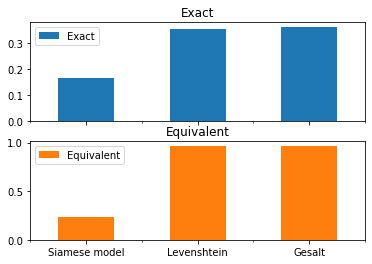

In [54]:
results.T.plot.bar(rot=0, subplots=True);

In [55]:
results.loc["Exact"].to_list()

[0.16696016189692658, 0.3527507326007326, 0.3601111133749291]

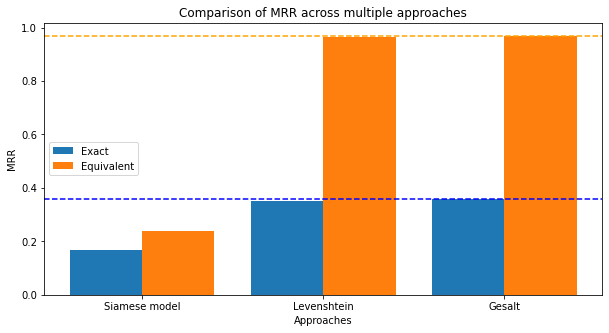

In [56]:
X = results.columns
Exact = results.loc["Exact"].to_list()
Equivalent = results.loc["Equivalent"].to_list()

X_axis = np.arange(len(X))
plt.figure(figsize=[10,5])

plt.bar(X_axis - 0.2, Exact, 0.4, label = 'Exact')
plt.bar(X_axis + 0.2, Equivalent, 0.4, label = 'Equivalent')

plt.axhline(y=max(Equivalent), color="orange", linestyle="--")
plt.axhline(y=max(Exact), color="blue", linestyle="--")
    
plt.xticks(X_axis, X)
plt.xlabel("Approaches")
plt.ylabel("MRR")
plt.title("Comparison of MRR across multiple approaches")
plt.legend()
plt.show()

# Translation tests

In [57]:
translation = '../data/translation_test_nps_202203171038.csv'
translation_set = preprocessInput(translation, maxlen = MAXLEN, balance= False, reflexive = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   np_name  5950 non-null   object
dtypes: object(1)
memory usage: 46.6+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['np_name'], dtype='object')
	New names: Index(['x'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 1 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 35 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       5914 non-null   object
dtypes: o

In [58]:
translation_set.head()

,x
0,XTNNP
1,NWLMKV
2,WZMFCEA
3,AARONSROD
4,AARONS ROD WHOLE


In [59]:
encode_pad_tag(translation_set, 1, 0, MAXLEN)

Encoding and Padding: ----------------------------------
	Processing x
Tagging: -----------------------------------------------


,x,Processed_x,Match,Distance
0,XTNNP,"[24, 20, 14, 14, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,0
1,NWLMKV,"[14, 23, 12, 13, 11, 22, 0, 0, 0, 0, 0, 0, 0, ...",1,0
2,WZMFCEA,"[23, 26, 13, 6, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,0
3,AARONSROD,"[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ...",1,0
4,AARONS ROD WHOLE,"[1, 1, 18, 15, 14, 19, 27, 18, 15, 4, 27, 23, ...",1,0
...,...,...,...,...
5909,ZINGIBER ZINGIBER WHOLE,"[26, 9, 14, 7, 9, 2, 5, 18, 27, 26, 9, 14, 7, ...",1,0
5910,ZYGAENA ERYTHRAEA WHOLE,"[26, 25, 7, 1, 5, 14, 1, 27, 5, 18, 25, 20, 8,...",1,0
5911,ZYGAENA INDICA WHOLE,"[26, 25, 7, 1, 5, 14, 1, 27, 9, 14, 4, 9, 3, 1...",1,0
5912,ZYGAENA LEWINI WHOLE,"[26, 25, 7, 1, 5, 14, 1, 27, 12, 5, 23, 9, 14,...",1,0


In [60]:
novelty = find_ranks(model, translation_set.sample(n=10), ranks=10, find_related_rank= False, report_distances=False)

NameError: name 'find_ranks' is not defined

In [ ]:
novelty.sample(10)

In [ ]:
# test["Processed_np_name"] = test.np_name.apply(clean).apply(encode).apply(padding)

In [ ]:
# test = preprocessInput(unmapped, converters = {"drug_name_original":str}, skip_blank_lines=True, na_filter=True, na_values="")
# test["Processed_drug_name_original"] = test[test.columns[0]].apply(clean).apply(encode).apply(padding)